# Philly Map Notebook

In [148]:
import requests
import pandas as pd
import geopandas as gp
import keplergl
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine

load_dotenv()

import seaborn as sns
from dotenv import load_dotenv
import os

In [149]:
FIPS_STATE = '42'
FIPS_COUNTY = '101'
ACS_YEAR = '2019'

[ACS variables dictionary](https://api.census.gov/data/2019/acs/acs5/variables.html)

In [150]:
ACS_VARS = 'B02001_001E,B02001_002E,B02001_003E,B19013_001E,B25071_001E,B17001_001E,B17001_002E'

# HUD Section 8 Vouchers by Tract

From the [HUD site](https://hudgis-hud.opendata.arcgis.com/datasets/housing-choice-vouchers-by-tract/)

In [151]:
hcv = pd.read_csv('hcv_tracts.csv')
hcv = hcv.rename(columns={'HCV_PUBLIC':'hcv_section_8_total_count'})
hcv['GEOID'] = hcv['GEOID'].astype(str)
hcv.head()

,OBJECTID,GEOID,STATE,COUNTY,TRACT,EACODE,EANAME,hcv_section_8_total_count,HCV_PCT_RENTER_OCC_UNITS,HCV_PUBLIC_PCT,SHAPE_Length,SHAPE_Area
0,1,4013104502,NaN,NaN,NaN,128.0,"Phoenix-Mesa-Scottsdale, AZ",35.0,3.87,3.87,0.054154,0.000130
1,2,4013105002,NaN,NaN,NaN,128.0,"Phoenix-Mesa-Scottsdale, AZ",NaN,NaN,NaN,0.143810,0.000781
2,3,4013107900,NaN,NaN,NaN,128.0,"Phoenix-Mesa-Scottsdale, AZ",48.0,8.16,8.16,0.142687,0.000755
3,4,4013108000,NaN,NaN,NaN,128.0,"Phoenix-Mesa-Scottsdale, AZ",NaN,NaN,NaN,0.089656,0.000370
4,5,4013116721,NaN,NaN,NaN,128.0,"Phoenix-Mesa-Scottsdale, AZ",NaN,NaN,NaN,0.071218,0.000222


# Census Tracts

In [152]:
URL = f"https://api.census.gov/data/{ACS_YEAR}/acs/acs5"
QUERY = f"?get=NAME,{ACS_VARS}&for=tract:*&in=state:{FIPS_STATE}+county:{FIPS_COUNTY}"
API_KEY = '&key=' + os.getenv('CENSUS_API_KEY')

In [153]:
vals = requests.get(URL+QUERY+API_KEY).json()

In [154]:
tract_id = [v[8] + v[9] + v[10] for v in vals]
pop = [v[1] for v in vals]
white = [v[2] for v in vals]
black = [v[3] for v in vals]
hh_income = [v[4] for v in vals]
rent_burden = [v[5] for v in vals]
impoverished_total = [v[6] for v in vals]
impoverished = [v[7] for v in vals]

In [155]:
df = pd.DataFrame({'tract_id':tract_id,'pop':pop,'white':white,'black':black,'hh_income':hh_income,'rent_burden':rent_burden,'impoverished':impoverished,'impoverished_total':impoverished_total}).drop(0).set_index('tract_id')

In [156]:
for c in df.columns:
    df[c] = df[c].astype(float)

In [157]:
df['pct_black'] = df['black']/df['pop']
df['pct_white'] = df['white']/df['pop']
df['pct_overall_black_population'] = df['black']/df.sum()['black']
df['poverty_rate'] = (df['impoverished']/df['impoverished_total']).round(3)
df = df.reset_index()

In [158]:
df = df.merge(hcv[['GEOID','hcv_section_8_total_count']],how='left',left_on='tract_id',right_on='GEOID').drop(columns='GEOID')
df['hcv_section_8_total_count'] = df['hcv_section_8_total_count'].mask(df['hcv_section_8_total_count'].isna(),0)

In [159]:
pct_cols = [c for c in df.columns if 'pct' in c]

for c in pct_cols:
    df[c] = (df[c]*100).round(2)

In [160]:
numeric = [n for n in df.select_dtypes(include=['int64','float64']).columns]
df[numeric] = df[numeric].mask(df[numeric] < 0,-1)

In [161]:
df.sort_values(by='rent_burden',ascending=False).head()

,tract_id,pop,white,black,hh_income,rent_burden,impoverished,impoverished_total,pct_black,pct_white,pct_overall_black_population,poverty_rate,hcv_section_8_total_count
146,42101026100,3192.0,103.0,3045.0,35708.0,51.0,528.0,3157.0,95.39,3.23,0.46,0.167,18.0
334,42101008801,2289.0,1189.0,272.0,31250.0,51.0,266.0,539.0,11.88,51.94,0.04,0.494,0.0
94,42101015300,4086.0,2075.0,1377.0,17202.0,51.0,2036.0,3345.0,33.70,50.78,0.21,0.609,30.0
327,42101007102,4570.0,229.0,4059.0,28321.0,51.0,1661.0,4570.0,88.82,5.01,0.61,0.363,73.0
153,42101039000,8641.0,1906.0,5356.0,29613.0,51.0,2948.0,8481.0,61.98,22.06,0.81,0.348,137.0


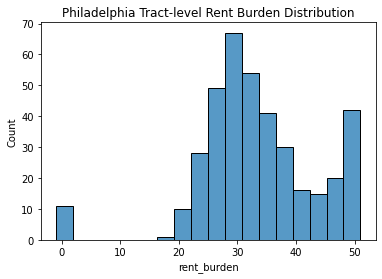

In [162]:
fig = sns.histplot(df.rent_burden)
fig.set_title('Philadelphia Tract-level Rent Burden Distribution')
plt.show()

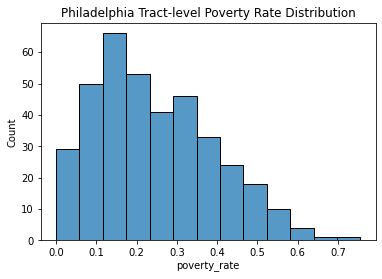

In [163]:
fig = sns.histplot(df.poverty_rate)
fig.set_title('Philadelphia Tract-level Poverty Rate Distribution')
plt.show()

Shapefiles can be downloaded from the [US Census site](https://www.census.gov/cgi-bin/geo/shapefiles/index.php)

In [164]:
shape_path = f"/Users/sinasinai/Desktop/tl_{ACS_YEAR}_{FIPS_STATE}_tract" 
gpdf = gp.read_file(shape_path)
gpdf = gpdf.loc[gpdf.COUNTYFP == FIPS_COUNTY]

In [165]:
philly = gpdf[['GEOID','geometry']].merge(df,left_on='GEOID',right_on='tract_id',how='inner').drop(columns='GEOID')

# Census Block Groups

In [166]:
URL = f"https://api.census.gov/data/{ACS_YEAR}/acs/acs5"
GEO = f"&for=block group:*&in=state:{FIPS_STATE}&in=county:{FIPS_COUNTY}&in=tract:*"
VAR = f"?get=NAME,{ACS_VARS}"
API_KEY = '&key=' + os.getenv('CENSUS_API_KEY')

In [167]:
vals = requests.get(URL+VAR+GEO+API_KEY).json()

In [168]:
# poverty rate statistics don't appear to be available for block group geos

In [169]:
block_group_id = [v[8] + v[9] + v[10] + v[11] for v in vals]
pop = [v[1] for v in vals]
white = [v[2] for v in vals]
black = [v[3] for v in vals]
hh_income = [v[4] for v in vals]
rent_burden = [v[5] for v in vals]
impoverished_total = [v[6] for v in vals]
impoverished = [v[7] for v in vals]

In [170]:
df = pd.DataFrame({'block_group_id':block_group_id,'pop':pop,'white':white,'black':black,'hh_income':hh_income,'rent_burden':rent_burden,'impoverished':impoverished,'impoverished_total':impoverished_total}).drop(0).set_index('block_group_id')

In [171]:
for c in df.columns:
    df[c] = df[c].astype(float)

In [172]:
df['pct_black'] = df['black']/df['pop']
df['pct_white'] = df['white']/df['pop']

In [173]:
numeric = [n for n in df.select_dtypes(include=['int64','float64']).columns]
df[numeric] = df[numeric].mask(df[numeric] < 0,-1)

In [174]:
df.head()

,pop,white,black,hh_income,rent_burden,impoverished,impoverished_total,pct_black,pct_white
block_group_id,,,,,,,,,
421019807001,0.0,0.0,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN
421010027013,1955.0,1029.0,262.0,55774.0,34.5,NaN,NaN,0.134015,0.526343
421010337012,976.0,709.0,0.0,41667.0,29.0,NaN,NaN,0.000000,0.726434
421010337013,3859.0,2583.0,477.0,37123.0,41.1,NaN,NaN,0.123607,0.669344
421010205002,1017.0,36.0,843.0,15743.0,29.5,NaN,NaN,0.828909,0.035398


In [175]:
df['pct_overall_black_population'] = df['black']/df.sum()['black']

In [176]:
pct_cols = [c for c in df.columns if 'pct' in c]

for c in pct_cols:
    df[c] = (df[c]*100).round(2)

In [177]:
df = df.reset_index()
df.sort_values(by='pct_black',ascending=False).head()

,block_group_id,pop,white,black,hh_income,rent_burden,impoverished,impoverished_total,pct_black,pct_white,pct_overall_black_population
415,421010264007,485.0,0.0,485.0,53906.0,-1.0,NaN,NaN,100.0,0.0,0.07
140,421010105001,265.0,0.0,265.0,-1.0,51.0,NaN,NaN,100.0,0.0,0.04
1250,421010168006,475.0,0.0,475.0,17083.0,51.0,NaN,NaN,100.0,0.0,0.07
199,421010259002,480.0,0.0,480.0,48517.0,50.0,NaN,NaN,100.0,0.0,0.07
201,421010259004,778.0,0.0,778.0,64830.0,31.4,NaN,NaN,100.0,0.0,0.12


In [178]:
shape_path = f"/Users/sinasinai/Desktop/tl_{ACS_YEAR}_{FIPS_STATE}_bg"
gpdf = gp.read_file(shape_path)
gpdf = gpdf.loc[gpdf.COUNTYFP == FIPS_COUNTY]

In [179]:
phillybg = gpdf[['GEOID','geometry']].merge(df,left_on='GEOID',right_on='block_group_id',how='inner').drop(columns='GEOID')

In [180]:
engine = create_engine(os.getenv('DB_URL'))
sql = ''' select * from renters where coordinates != 'nan' '''
renters = pd.read_sql(sql,engine)

def extract_lng(x):
    return float(x.replace('[','').replace(']','').split(', ')[0])

def extract_lat(x):
    return float(x.replace('[','').replace(']','').split(', ')[1])

renters['longitude'] = renters.coordinates.apply(lambda x: extract_lng(x))
renters['latitude'] = renters.coordinates.apply(lambda x: extract_lat(x))

renters_geo = gp.GeoDataFrame(geometry=gp.points_from_xy(renters.longitude, renters.latitude),data=renters)
renters_geo = renters_geo.drop(columns=['coordinates','longitude','latitude'])

renters_geo.head()

,address,zip_code,market_value,opa_account_number,opa_owner,rental_license_number,most_recent_license_issue_date,license_expiration_date,license_inactive_date,license_status,...,owner_2,parcel_number,properties_recording_date,sale_price,taxable_building,taxable_land,total_area,total_livable_area,zoning,geometry
0,1 ACADEMY CIR,19146-5238,220000,888300620,"HEIDEMANN STEPHANIE, ALIMOHAMMADI FARBOD",835117,2021-01-17T00:00:00Z,2022-01-26T12:57:31Z,nan,Active,...,BERNHARD ERIC J,888300548,2020-03-13T00:00:00Z,240000,194080,25920,0.0,420.0,RMX1,POINT (-75.18428 39.94405)
1,1 CHRISTIAN ST,19147-4345,639800,888020031,"HARTZELL ANDERSON LEE, HARTZELL THERESA ANN",834411,2021-01-19T00:00:00Z,2022-01-16T14:13:22Z,nan,Active,...,SIDDIQUI SAFIA,022093294,2020-06-24T00:00:00Z,1,402882,191918,1690.0,2400.0,RM1,POINT (-75.14296 39.93525)
2,1 EARL CT,19125-3336,203900,181121500,ADAMS BRENNA L,786388,2020-08-25T00:00:00Z,2021-08-15T00:00:00Z,nan,Active,...,nan,181121500,2015-10-09T00:00:00Z,183000,97730,61170,637.0,915.0,RSA5,POINT (-75.13044 39.97307)
3,1 FRANKLIN TOWN BLVD,19102-0000,47628600,881146350,"FOREST CITY FRANKLIN, TOWN CORP",218261,2020-03-02T00:00:00Z,2021-02-28T00:00:00Z,nan,Active,...,TOWN CORP,881146350,1987-02-19T00:00:00Z,1,33340020,14288580,42094.0,416100.0,CMX4,POINT (-75.16734 39.95988)
4,1 LINDEN TER,19144-2907,126600,124010100,YELLOCK MONICA,243138,2003-10-23T00:00:00Z,2004-02-29T00:00:00Z,2012-12-22T11:51:54Z,Inactive,...,nan,124010100,2020-02-04T00:00:00Z,1,62610,18990,1387.24,1611.0,RSA3,POINT (-75.17008 40.03135)


In [181]:
m = keplergl.KeplerGl()
m.add_data(data=philly,name=f"ACS - 5 Year {ACS_YEAR} - Census Tracts")
m.add_data(data=phillybg,name=f"ACS - 5 Year {ACS_YEAR} - Block Groups")
m.add_data(data=renters_geo,name='Rental Units')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [206]:
m

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'cxvg6w', 'type': '…

In [211]:
config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'cxvg6w',
     'type': 'geojson',
     'config': {'dataId': 'Rental Units',
      'label': 'Rental Units',
      'color': [23, 184, 190],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'strokeOpacity': 0.8,
       'thickness': 0.2,
       'strokeColor': [105, 79, 214],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 7,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'o7ga4f6',
     'type': 'geojson',
     'config': {'dataId': 'ACS - 5 Year 2019 - Block Groups',
      'label': 'ACS - 5 Year 2019 - Block Groups',
      'color': [246, 209, 138],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.1,
       'strokeOpacity': 0.2,
       'thickness': 0.5,
       'strokeColor': [118, 183, 61],
       'colorRange': {'name': 'ColorBrewer YlOrRd-6',
        'type': 'sequential',
        'category': 'ColorBrewer',
        'colors': ['#ffffb2',
         '#fed976',
         '#feb24c',
         '#fd8d3c',
         '#f03b20',
         '#bd0026']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'rent_burden', 'type': 'real'},
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'uz2vizv',
     'type': 'geojson',
     'config': {'dataId': 'ACS - 5 Year 2019 - Census Tracts',
      'label': 'ACS - 5 Year 2019 - Census Tracts',
      'color': [119, 110, 87],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.1,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [87, 173, 87],
       'colorRange': {'name': 'ColorBrewer YlOrRd-6',
        'type': 'sequential',
        'category': 'ColorBrewer',
        'colors': ['#ffffb2',
         '#fed976',
         '#feb24c',
         '#fd8d3c',
         '#f03b20',
         '#bd0026']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'poverty_rate', 'type': 'real'},
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'ACS - 5 Year 2019 - Census Tracts': [{'name': 'tract_id',
        'format': None},
       {'name': 'pop', 'format': None},
       {'name': 'hh_income', 'format': None},
       {'name': 'rent_burden', 'format': None},
       {'name': 'pct_black', 'format': None},
       {'name': 'pct_white', 'format': None},
       {'name': 'hcv_section_8_total_count', 'format': None},
       {'name': 'poverty_rate', 'format': None}],
      'ACS - 5 Year 2019 - Block Groups': [{'name': 'block_group_id',
        'format': None},
       {'name': 'pop', 'format': None},
       {'name': 'white', 'format': None},
       {'name': 'black', 'format': None},
       {'name': 'hh_income', 'format': None}],
      'Rental Units': [{'name': 'address', 'format': None},
       {'name': 'zip_code', 'format': None},
       {'name': 'market_value', 'format': None},
       {'name': 'opa_account_number', 'format': None},
       {'name': 'opa_owner', 'format': None},
       {'name': 'license_status', 'format': None},
       {'name': 'legal_entity_type', 'format': None},
       {'name': 'legal_property_owner_name', 'format': None},
       {'name': 'business_name', 'format': None},
       {'name': 'building_code', 'format': None},
       {'name': 'category_code', 'format': None},
       {'name': 'rooms', 'format': None},
       {'name': 'stories', 'format': None},
       {'name': 'owner_1', 'format': None},
       {'name': 'owner_2', 'format': None},
       {'name': 'zoning', 'format': None},
       {'name': 'total_livable_area', 'format': None},
       {'name': 'rental_license_number', 'format': None},
       {'name': 'number_of_units', 'format': None},
       {'name': 'license_expiration_date', 'format': None},
       {'name': 'parcel_number', 'format': None},
       {'name': 'total_area', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': True},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 39.966937679150895,
   'longitude': -75.19553253464898,
   'pitch': 0,
   'zoom': 11.435955387970616,
   'isSplit': False},
  'mapStyle': {'styleType': 'muted',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': True,
    'building': True,
    'water': True,
    'land': True,
    '3d building': True},
   'threeDBuildingColor': [192, 192, 192],
   'mapStyles': {}}}}

In [212]:
m.config = config

In [213]:
m.save_to_html(file_name="philly.html")

Map saved to philly.html!


In [214]:
philly.describe().round(2)

,pop,white,black,hh_income,rent_burden,impoverished,impoverished_total,pct_black,pct_white,pct_overall_black_population,poverty_rate,hcv_section_8_total_count
count,384.00,384.00,384.00,384.00,384.00,384.00,384.00,376.00,376.00,384.00,376.00,384.00
mean,4112.17,1672.03,1732.64,48107.42,33.33,973.25,3998.12,43.00,41.04,0.26,0.24,44.40
std,1798.03,1517.88,1609.95,26047.37,10.27,755.69,1822.52,34.35,30.82,0.24,0.15,55.37
min,0.00,0.00,0.00,-1.00,-1.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00
25%,2819.50,295.75,381.75,28936.25,27.80,366.50,2775.50,10.40,10.29,0.06,0.13,0.00
50%,4056.00,1311.00,1243.00,43702.00,32.20,804.50,3949.50,32.81,38.68,0.18,0.22,27.00
75%,5185.00,2672.25,2845.00,61465.50,38.62,1359.50,5105.25,80.43,70.13,0.43,0.34,70.00
max,8912.00,6415.00,7121.00,143646.00,51.00,4005.00,8823.00,98.52,98.53,1.07,0.76,438.00


In [215]:
phillybg.describe().round(2)

,pop,white,black,hh_income,rent_burden,impoverished,impoverished_total,pct_black,pct_white,pct_overall_black_population
count,1336.00,1336.00,1336.00,1336.00,1336.00,0.0,0.0,1328.00,1328.00,1336.00
mean,1181.94,480.58,498.00,44442.70,30.19,NaN,NaN,46.31,38.05,0.07
std,586.26,509.55,455.48,30073.91,16.07,NaN,NaN,36.63,32.58,0.07
min,0.00,0.00,0.00,-1.00,-1.00,NaN,NaN,0.00,0.00,0.00
25%,775.25,53.75,114.00,24341.25,22.87,NaN,NaN,9.74,6.01,0.02
50%,1073.50,333.00,395.50,41250.00,30.65,NaN,NaN,39.80,31.80,0.06
75%,1473.00,753.00,749.25,61432.50,43.12,NaN,NaN,85.42,66.97,0.11
max,4099.00,2831.00,2991.00,189886.00,51.00,NaN,NaN,100.00,100.00,0.45


In [216]:
philly.sort_values(by='poverty_rate',ascending=False)[['tract_id','pop','pct_black','hh_income','poverty_rate','pct_overall_black_population']].head(25).set_index('tract_id')

,pop,pct_black,hh_income,poverty_rate,pct_overall_black_population
tract_id,,,,,
42101014700,2686.0,49.74,10793.0,0.756,0.20
42101008802,6303.0,21.94,22104.0,0.646,0.21
42101017702,5188.0,22.55,23336.0,0.629,0.18
42101017602,4603.0,13.53,23630.0,0.628,0.09
42101015300,4086.0,33.70,17202.0,0.609,0.21
42101989100,1811.0,74.16,-1.0,0.608,0.20
42101009000,6201.0,7.84,25515.0,0.580,0.07
42101029300,3170.0,23.75,25982.0,0.577,0.11
42101016500,3180.0,89.34,13235.0,0.564,0.43


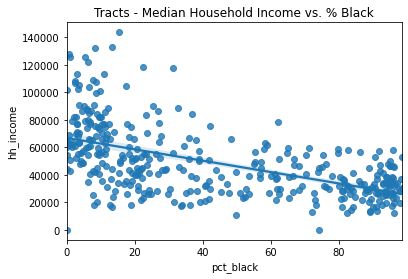

In [217]:
f = sns.regplot(x=philly.pct_black,y=philly.hh_income)
f.set_title("Tracts - Median Household Income vs. % Black")
plt.show()

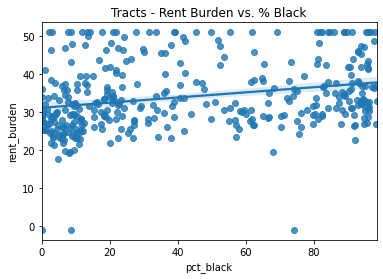

In [218]:
f = sns.regplot(x=philly.pct_black,y=philly.rent_burden)
f.set_title("Tracts - Rent Burden vs. % Black")
plt.show()

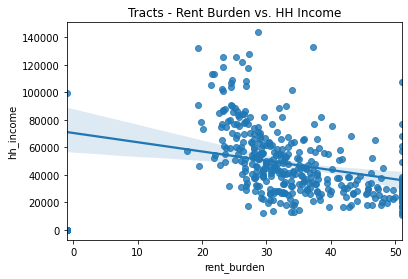

In [219]:
f = sns.regplot(x=philly.rent_burden,y=philly.hh_income)
f.set_title("Tracts - Rent Burden vs. HH Income")
plt.show()

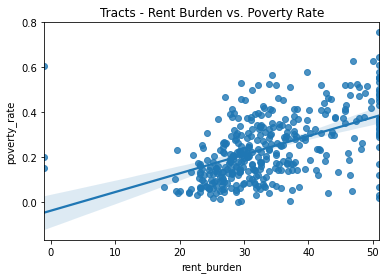

In [220]:
f = sns.regplot(x=philly.rent_burden,y=philly.poverty_rate)
f.set_title("Tracts - Rent Burden vs. Poverty Rate")
plt.show()

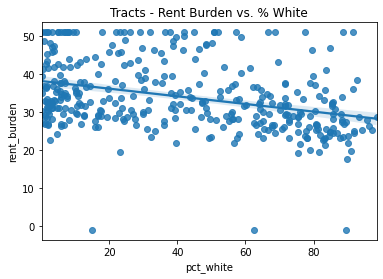

In [221]:
f = sns.regplot(x=philly.pct_white,y=philly.rent_burden)
f.set_title("Tracts - Rent Burden vs. % White")
plt.show()

In [222]:
philly.corr()['pct_black']

pop                            -0.061625
white                          -0.794052
black                           0.856623
hh_income                      -0.559359
rent_burden                     0.256361
impoverished                    0.289152
impoverished_total             -0.045975
pct_black                       1.000000
pct_white                      -0.925087
pct_overall_black_population    0.856682
poverty_rate                    0.426695
hcv_section_8_total_count       0.484809
Name: pct_black, dtype: float64

In [223]:
philly.corr()['rent_burden']

pop                             0.347431
white                          -0.078053
black                           0.342567
hh_income                      -0.265065
rent_burden                     1.000000
impoverished                    0.545204
impoverished_total              0.311232
pct_black                       0.256361
pct_white                      -0.341747
pct_overall_black_population    0.342314
poverty_rate                    0.510803
hcv_section_8_total_count       0.341710
Name: rent_burden, dtype: float64

In [224]:
philly.corr()['pct_white']

pop                            -0.030054
white                           0.814472
black                          -0.817603
hh_income                       0.692099
rent_burden                    -0.341747
impoverished                   -0.461813
impoverished_total             -0.039512
pct_black                      -0.925087
pct_white                       1.000000
pct_overall_black_population   -0.817770
poverty_rate                   -0.570597
hcv_section_8_total_count      -0.485956
Name: pct_white, dtype: float64

In [225]:
print(f"Overall Philly poverty rate {100*(philly.sum()['impoverished']/philly.sum()['impoverished_total']).round(5)}%")

Overall Philly poverty rate 24.343%
